# Exercise 5

### Necessary imports

In [10]:
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel
from gensim import corpora
from gensim.models import CoherenceModel
import warnings
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
warnings.filterwarnings("ignore")
from datasets import load_dataset
import spacy

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

stop_words = stopwords.words('english')
plt.style.use('dark_background')

### Dataset loading

In [11]:
dataset = load_dataset("okite97/news-data")
df = pd.DataFrame(dataset['train'])

Found cached dataset csv (C:/Users/lores/.cache/huggingface/datasets/okite97___csv/okite97--news-data-15d8f79c697f14ed/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
100%|██████████| 2/2 [00:00<00:00, 496.90it/s]


### Pre-processing of dataset

In [12]:
def preprocess(sentence):
    # Maintain only content words (nouns, verbs, adjectives, adverbs) of the sentence with minimum length of 4 characters, remove stopwords and punctuation
    sentence = nlp(sentence)
    sentence = [token.lemma_ for token in sentence if token.pos_ in ['NOUN'] and len(token.lemma_) > 3 and token.lemma_ not in stop_words and not token.is_punct]
    return sentence

In [13]:
df['text_cleaned'] = df['Excerpt'].apply(preprocess)

### Visualizing the correct CloudWords for each topics

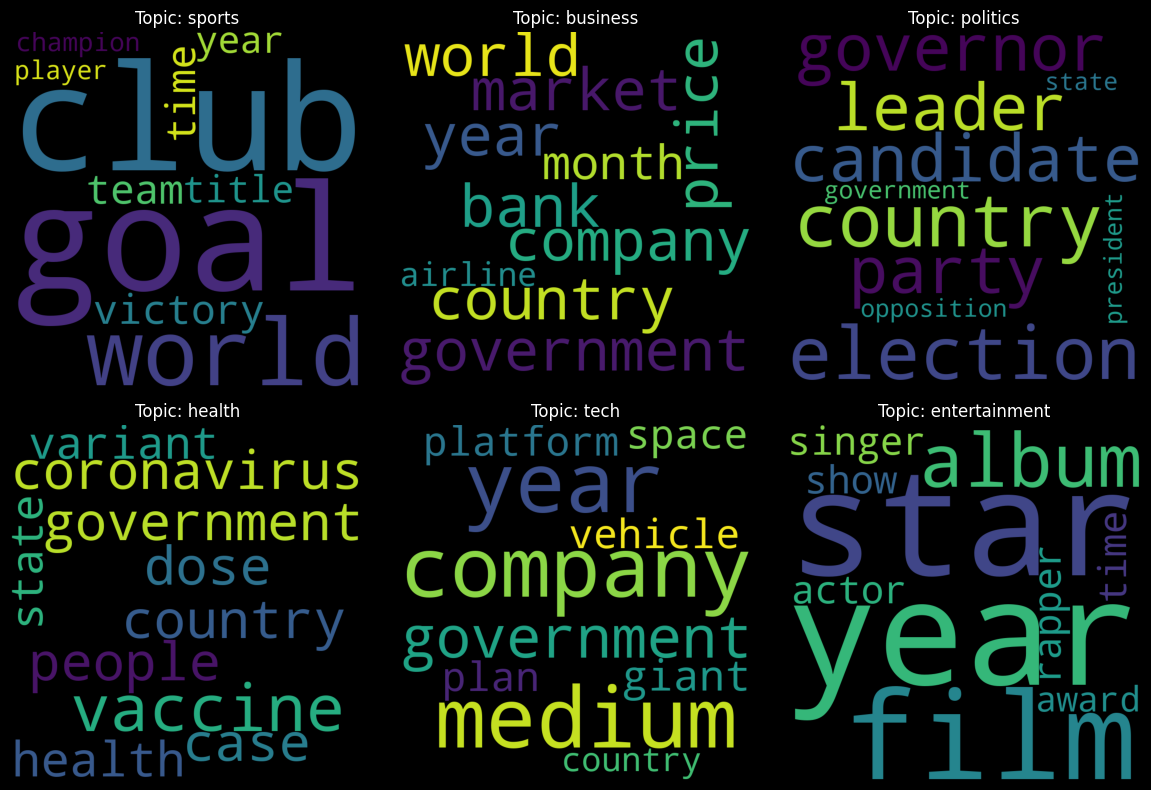

In [14]:
topics = df['Category'].unique()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for topic in topics:
    # Get all the sentences for a particular topic
    sentences = df[df['Category'] == topic]['text_cleaned'].tolist()
    
    # Count frequency of words in the sentences
    word_freq = {}
    for sentence in sentences:
        for word in sentence:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    word_freq = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)}
    
    # Get the top 10 words and create the WordCloud
    top_10_words = list(word_freq.keys())[:10]
    wc = WordCloud(width=800, height=800, background_color='black', min_font_size=10).generate(' '.join(top_10_words))
    plt.subplot(2, 3, list(topics).index(topic) + 1)
    plt.title(f"Topic: {topic}")
    plt.axis('off')
    plt.imshow(wc)

### Creating the Dictionary and Corpus needed for Topic Modeling

In [15]:
# Tokenize the texts
texts = df['text_cleaned']

# Create Dictionary
id2word = corpora.Dictionary(texts)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

## First Method: LDA for topic modeling

### Hyperparameter tuning

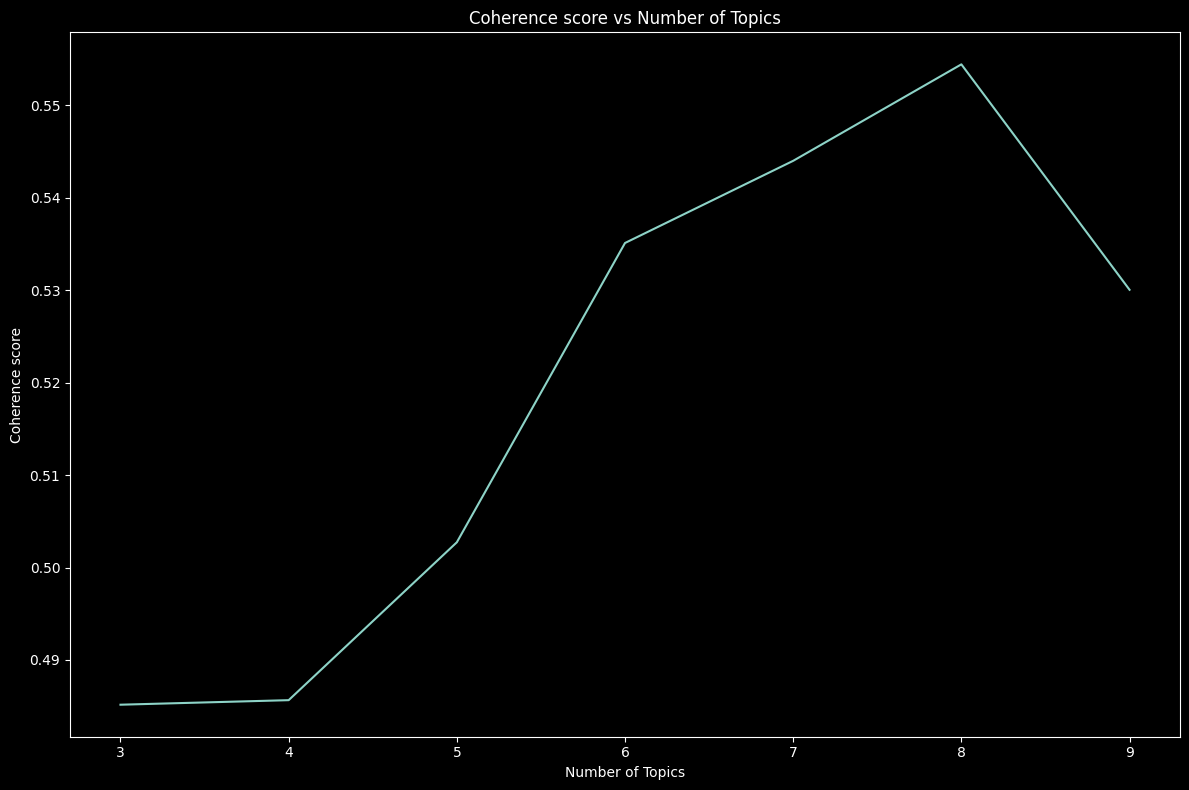

In [16]:
def calculate_coherence_score_lda(n):
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# List containing various hyperparameters
no_of_topics = [3, 4, 5, 6, 7, 8, 9]

best_coherence_score = 0
best_n = 0

coherence_scores = []
for n in no_of_topics:
    coherence_score = calculate_coherence_score_lda(n)
    coherence_scores.append(coherence_score)
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_n = n

# Plot the coherence score for each number of topics
plt.figure(figsize=(12, 8))
plt.plot(no_of_topics, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence score vs Number of Topics")
plt.show()

### Visualizing the topics with pyLDAvis

In [17]:
# Best model
best_lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=best_n,
                     random_state=42)
                        
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.145698 -0.078723       1        1  14.039749
5      0.105832 -0.043594       2        1  13.775785
4      0.042672  0.154708       3        1  13.210683
1     -0.176343  0.016890       4        1  12.546234
2     -0.052926 -0.115658       5        1  12.211132
6     -0.080559  0.073053       6        1  11.676239
7      0.065469  0.103122       7        1  11.555764
0     -0.049844 -0.109797       8        1  10.984413, topic_info=           Term        Freq       Total Category  logprob  loglift
110       world  142.000000  142.000000  Default  30.0000  30.0000
80     election  123.000000  123.000000  Default  29.0000  29.0000
252    governor   71.000000   71.000000  Default  28.0000  28.0000
200     vaccine  155.000000  155.000000  Default  27.0000  27.0000
15      country  243.000000  243.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1036    project    9.579290   18.421865   Topic8  -5.2084   1.5548
180   operation   10.026729   23.259704   Topic8  -5.1627   1.3672
200     vaccine   10.492454  155.368638   Topic8  -5.1173  -0.4865
113       child    9.138297   24.632949   Topic8  -5.2555   1.2171
131        team    9.349749   65.836782   Topic8  -5.2326   0.2569

[523 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
575       4  0.958073   abuse
692       3  0.221585  action
692       4  0.620437  action
692       5  0.044317  action
692       6  0.044317  action
...     ...       ...     ...
17        7  0.383906    year
17        8  0.037917    year
1706      4  0.116509    zone
1706      6  0.815563    zone
1846      4  0.943291  zoning

[1140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 5, 2, 3, 7, 8, 1])

### Create Cloud Words for each topic

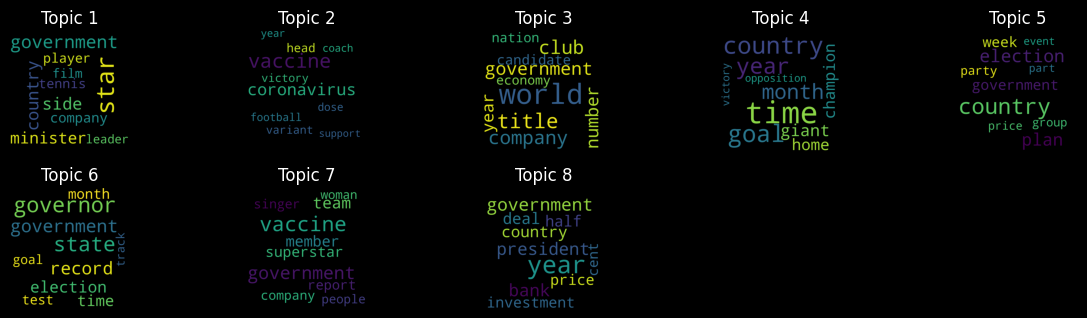

In [18]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for i in range(best_n):
    words = best_lda_model.show_topics()[i][1].split('+')
    top_terms_key = {}
    for term in words:
        word = term.split('*')[1].replace('"', '')
        freq = term.split('*')[0]
        top_terms_key[word] = float(freq)
    wc = WordCloud(width=800, height=800, background_color='black', min_font_size=10).generate_from_frequencies(top_terms_key)
    plt.subplot(int(best_n / 2) + 1, int(best_n / 2) + 1, i+1)
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.imshow(wc)

## Second Method: LSA for topic modeling

### Creating the corpus and dictionary

In [19]:
# Tokenize the text with NLTK
texts = df['text_cleaned']

# Create Dictionary
id2word = corpora.Dictionary(texts)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

### Hyperparameter tuning for LSA

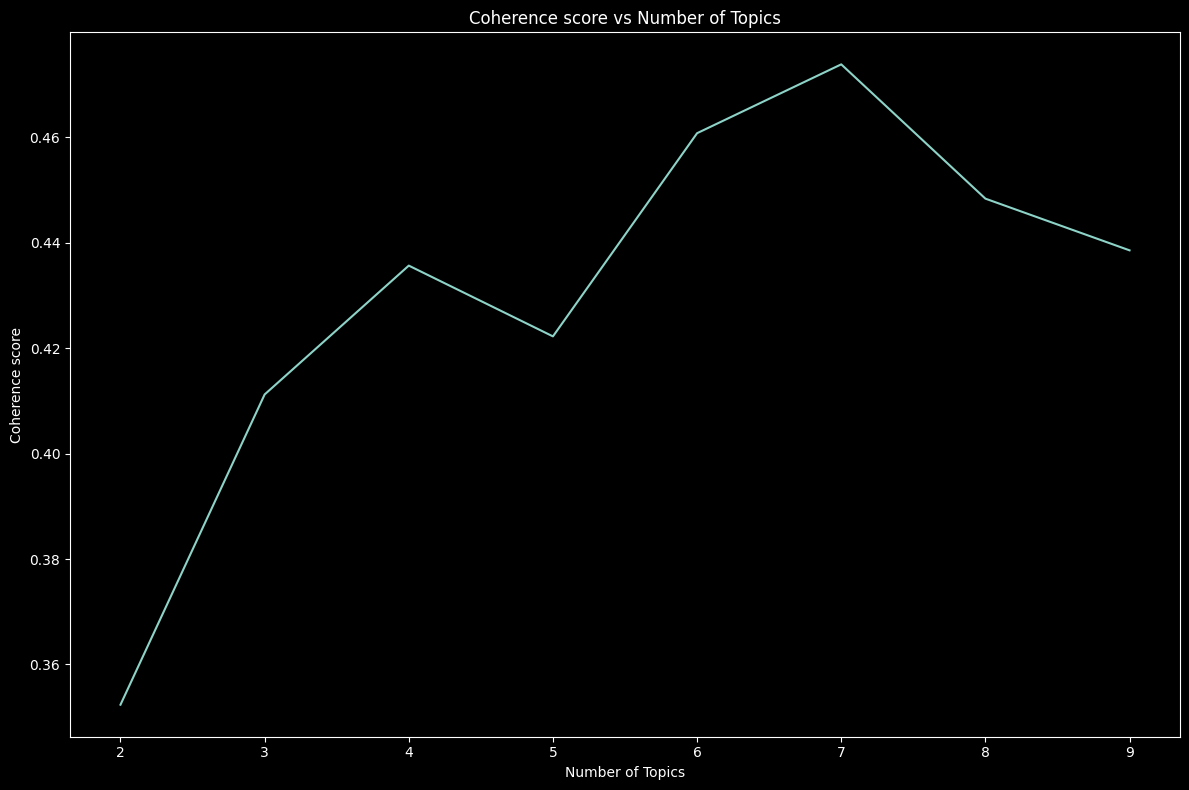

In [20]:
def calculate_coherence_score_lsi(n):
    lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=n, random_seed=42)
    coherence_model_lsi = CoherenceModel(model=lsi_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lsi = coherence_model_lsi.get_coherence()
    return coherence_lsi

# List containing various hyperparameters
no_of_topics = [2, 3, 4, 5, 6, 7, 8, 9]

best_coherence_score = 0
best_n = 0

coherence_scores = []
for n in no_of_topics:
    coherence_score = calculate_coherence_score_lsi(n)
    coherence_scores.append(coherence_score)
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_n = n

# Plot the coherence score for each number of topics
plt.figure(figsize=(12, 8))
plt.plot(no_of_topics, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence score vs Number of Topics")
plt.show()

### Creating the WordClouds for each topic

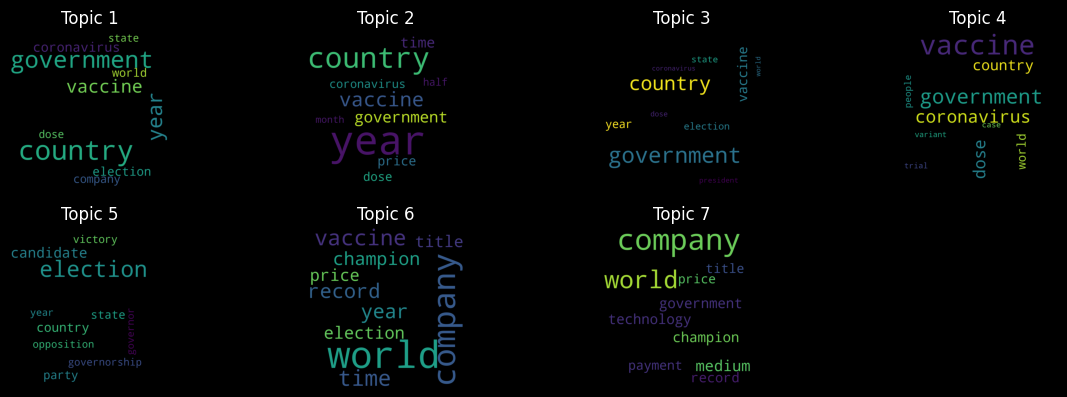

In [21]:
import numpy as np

best_lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=best_n, random_seed=42)

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for i in range(best_n):
    words = best_lsi_model.show_topics()[i][1].split('+')
    top_terms_key = {}
    for term in words:
        word = term.split('*')[1].replace('"', '')
        freq = abs(float(term.split('*')[0]))
        top_terms_key[word] = float(freq)

    norm_1 = np.abs([val for val in top_terms_key.values()]).sum(axis=0)
    normalized_top_terms_key = {key:top_terms_key[key]/norm_1 for key in top_terms_key.keys()}
    
    wc = WordCloud(width=800, height=800, background_color='black', min_font_size=10).generate_from_frequencies(normalized_top_terms_key)
    plt.subplot(int(best_n / 2) + 1, int(best_n / 2) + 1, i+1)
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.imshow(wc)